# Exploring NHANES 2003 - 2006 Health and Nutrition Data in Relationship to Mortality With Focus on Morphometrics, with Activity and Hypertension as Proxies for Metabolic Balance. 


### Additional Features to Explore Include: Occupation, prescription medication and other features that influence respiration, and therefore metabolism and energetics across time

###### 1. Introduction: Overall health and longevity is correlated with the energy balance in day to day living. The better the balance in energy availability, the better the energy balance and the longer the longevity. Energy production, in it's most simplified form, is dependent on the food consumption, transformed essentially to glucose, and Oxygen consumption, providing units of energy in the form of the chemical Adenosine Triphosphate (ATP). The byproducts of this reaction, which is ubiquitous in all the cells of the body are water and CO<sub>2</sub>.

The NHANES data is a continuous effort to gather subjective and objective data from respondents every 2 years. Some information is publically available, but other information is available by request, such as mortality data (1).

The data is available in XPT format, a SAS format. The files may be downloaded from the CDC site by year and by subset. To convert the data to csv format, SAS Universal Viewer is used. 

In this work, the xpt files were downloaded individually in the xpt format, along with the htm definitions htm file for the data fields. In the xpt viewer, the file is opened by double clicking the file (assuming the viewer was installed, and then clicking on the file, and in the opened data file, right-clicking the the table and saving as a csv file. The accompanying data folder has the xpt and csv file of interest split into folders: 2003-2004, 2005-2006, combined data folder.

Selection of the data sets and fields of interest was carried out after merging all the definition data of the fields into a single csv, facilitating filtering to data subsets.

The basis of this work is Laroux et. al's (2) investigation "Organizing and analyzing the activity data in NHANES". Laroux, et al. "provide the tools to transition from "available data online" to "easily accessible and usable data", which substantially reduces the large upfront costs of initiating studies of association between physical activity and human health outcomes using NHANES. We apply these tools in an analysis showing that accelerometry features have the potential to predict 5-year all cause mortality better than known risk factors such as age, cigarette smoking, and various comorbidities".

Their work simplifies the acquisition of activities data from the accelerometer data for the period 2003 - 2006 of data collection and correlates with mortality. The period includes 2 intervals, i.e. 2 sets of data.

Building on their work, one can acquire their data set, using "R" and their scripts. Included in the relevant folder. 

With acquiring the other data sets of all the desired features, analyses may be performed regarding all the features (data) in NHANES 2003 - 2006 to conduct correlation studies and answer questions related to mortality, activity, hypertension, medication use, psychiatry, occupation, laboratory data among many others.

The thesis of this work is that how one breathes through their day and night relates to their morphometrics, day respiration during activities and in sleep and therefore impacts their their morbidities and mortality probabilities.

Although laborious, more data was downloaded than needed in this work. the intent is to avail the data and examples of analyses to facilitate future analyses, exploration, expansion and teaching. 

A special thanks goes out to Dr. Leroux et al. making this work possible.

1. Centers for Disease Control and Prevention: About the national health and nutrition examination survey (2017). URL http://www.cdc.gov/nchs/nhanes/about_nhanes.htm
2. Leroux A, Di J, Smirnova E, Mcguffey EJ, Cao Q, Bayatmokhtari E, Tabacu L, Zipunnikov V, Urbanek JK, Crainiceanu C. Organizing and analyzing the activity data in NHANES. Stat Biosci. 2019 Jul;11(2):262-287. doi: 10.1007/s12561-018-09229-9. Epub 2019 Feb 9. PMID: 32047572; PMCID: PMC7012355..1007/s12561-018-09229-9.

In [3]:
import pandas as pd
import json

import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from nhanes.utils import get_nhanes_year_code_dict, get_source_code_from_filepath
from nhanes.utils import EmptySectionError, make_long_variable_name
from nhanes.utils import get_vars_to_keep, get_datasets

In [4]:
import json
import pandas as pd

# Load the JSON file and remove comments
file_path = '../data/nhanes_variables.json'
cleaned_lines = []
with open(file_path, 'r') as file:
    for line in file:
        cleaned_line = line.split('//')[0].strip()
        if cleaned_line:
            cleaned_lines.append(cleaned_line)
cleaned_json = '\n'.join(cleaned_lines)
nhanes_data = json.loads(cleaned_json)

# Convert JSON to DataFrame
nhanes_list = [{"Variable": key, "Codes": ", ".join(value)} for key, value in nhanes_data.items()]
nhanes_df = pd.DataFrame(nhanes_list)

# Save to CSV
csv_path = '../data/nhanes_variables_selected1.csv'
nhanes_df.to_csv(csv_path, index=False)



In [4]:
# Load the TSV file and convert it to CSV
tsv_file_path = '../data/NHANES_metadata_2017-2018.tsv'
csv_output_path = '../data/NHANES_metadata_2017-2018.csv'

# Read the TSV file into a DataFrame
tsv_df = pd.read_csv(tsv_file_path, sep='\t')

# Save as CSV
tsv_df.to_csv(csv_output_path, index=False)

csv_output_path


'../data/NHANES_metadata_2017-2018.csv'

In [7]:
# Combining Body Measurements

# File paths
file_c_path = '../data/raw_data/2003-2004a/BMX_C.csv'
file_d_path = '../data/raw_data/2005-2006/BMX_D.csv'
combined_file_path = '../data/dataCombined/combined_BMX_2003_2006two.csv' 

# Load the CSV files
df_c = pd.read_csv(file_c_path)
df_d = pd.read_csv(file_d_path)

# Verify columns match
# if list(df_c.columns) != list(df_d.columns):
#     raise ValueError("Columns do not match between the two files.")

# Find common columns between the two files
common_columns = list(set(df_c.columns).intersection(set(df_d.columns)))

# Filter the dataframes to only include the common columns
# df_c_filtered = df_c[common_columns]
# df_d_filtered = df_d[common_columns]

df_c_filtered = df_c[common_columns].copy()
df_d_filtered = df_d[common_columns].copy()

# Add a source column to indicate the year
df_c_filtered['SourceYear'] = 2003
df_d_filtered['SourceYear'] = 2005

# Combine the dataframes
combined_df = pd.concat([df_c_filtered, df_d_filtered], ignore_index=True)

# Ensure SEQN is the first column
if 'SEQN' in combined_df.columns:
    columns = ['SEQN'] + [col for col in combined_df.columns if col != 'SEQN']
    combined_df = combined_df[columns]
    
# Save the combined dataframe to CSV
combined_df.to_csv(combined_file_path, index=False)

In [8]:
# Combining Blood Pressure Exam data

# File paths
file_c_path = '../data/raw_data/2003-2004a/BPX_C.csv'
file_d_path = '../data/raw_data/2005-2006/BPX_D.csv'
combined_file_path = '../data/dataCombined/combined_BPX_2003_2006two.csv' 

# Load the CSV files
df_c = pd.read_csv(file_c_path)
df_d = pd.read_csv(file_d_path)

# Verify columns match
# if list(df_c.columns) != list(df_d.columns):
#     raise ValueError("Columns do not match between the two files.")

# Find common columns between the two files
common_columns = list(set(df_c.columns).intersection(set(df_d.columns)))

# Filter the dataframes to only include the common columns
# df_c_filtered = df_c[common_columns]
# df_d_filtered = df_d[common_columns]

df_c_filtered = df_c[common_columns].copy()
df_d_filtered = df_d[common_columns].copy()

# Add a source column to indicate the year
df_c_filtered['SourceYear'] = 2003
df_d_filtered['SourceYear'] = 2005

# Combine the dataframes
combined_df = pd.concat([df_c_filtered, df_d_filtered], ignore_index=True)

# Ensure SEQN is the first column
if 'SEQN' in combined_df.columns:
    columns = ['SEQN'] + [col for col in combined_df.columns if col != 'SEQN']
    combined_df = combined_df[columns]

# Save the combined dataframe to CSV
combined_df.to_csv(combined_file_path, index=False)

In [20]:
# Combining Blood Pressure Questionnaire data

# File paths
file_c_path = '../data/raw_data/2003-2004a/BPQ_C.csv'
file_d_path = '../data/raw_data/2005-2006/BPQ_D.csv'
combined_file_path = '../data/dataCombined/combined_BPQ_2003_2006.csv' 

# Load the CSV files
df_c = pd.read_csv(file_c_path)
df_d = pd.read_csv(file_d_path)

# Verify columns match
# if list(df_c.columns) != list(df_d.columns):
#     raise ValueError("Columns do not match between the two files.")

# Find common columns between the two files
common_columns = list(set(df_c.columns).intersection(set(df_d.columns)))

# Filter the dataframes to only include the common columns
# df_c_filtered = df_c[common_columns]
# df_d_filtered = df_d[common_columns]

df_c_filtered = df_c[common_columns].copy()
df_d_filtered = df_d[common_columns].copy()

# Add a source column to indicate the year
df_c_filtered['SourceYear'] = 2003
df_d_filtered['SourceYear'] = 2005

# Combine the dataframes
combined_df = pd.concat([df_c_filtered, df_d_filtered], ignore_index=True)

# Ensure SEQN is the first column
if 'SEQN' in combined_df.columns:
    columns = ['SEQN'] + [col for col in combined_df.columns if col != 'SEQN']
    combined_df = combined_df[columns]

# Save the combined dataframe to CSV
combined_df.to_csv(combined_file_path, index=False)

In [10]:
# Combining Blood Pressure Exam data

# File paths
file_c_path = '../data/raw_data/2003-2004a/DEMO_C.csv'
file_d_path = '../data/raw_data/2005-2006/DEMO_D.csv'
combined_file_path = '../data/dataCombined/combined_DEMO_2003_2006.csv' 

# Load the CSV files
df_c = pd.read_csv(file_c_path)
df_d = pd.read_csv(file_d_path)

# Verify columns match
# if list(df_c.columns) != list(df_d.columns):
#     raise ValueError("Columns do not match between the two files.")

# Find common columns between the two files
common_columns = list(set(df_c.columns).intersection(set(df_d.columns)))

# Filter the dataframes to only include the common columns
# df_c_filtered = df_c[common_columns]
# df_d_filtered = df_d[common_columns]

df_c_filtered = df_c[common_columns].copy()
df_d_filtered = df_d[common_columns].copy()

# Add a source column to indicate the year
df_c_filtered['SourceYear'] = 2003
df_d_filtered['SourceYear'] = 2005

# Combine the dataframes
combined_df = pd.concat([df_c_filtered, df_d_filtered], ignore_index=True)

# Ensure SEQN is the first column
if 'SEQN' in combined_df.columns:
    columns = ['SEQN'] + [col for col in combined_df.columns if col != 'SEQN']
    combined_df = combined_df[columns]

# Save the combined dataframe to CSV
combined_df.to_csv(combined_file_path, index=False)

In [25]:
# Combining Prescription Questionnaire data

# File paths
file_c_path = '../data/raw_data/2003-2004a/RXQ_RX_C.csv'
file_d_path = '../data/raw_data/2005-2006/RXQ_RX_D.csv'
combined_file_path = '../data/dataCombined/combined_RXQ_RX_2003_2006.csv' 

# Load the CSV files
df_c = pd.read_csv(file_c_path)
df_d = pd.read_csv(file_d_path)

# Verify columns match
# if list(df_c.columns) != list(df_d.columns):
#     raise ValueError("Columns do not match between the two files.")

# Find common columns between the two files
common_columns = list(set(df_c.columns).intersection(set(df_d.columns)))

# Filter the dataframes to only include the common columns
# df_c_filtered = df_c[common_columns]
# df_d_filtered = df_d[common_columns]

df_c_filtered = df_c[common_columns].copy()
df_d_filtered = df_d[common_columns].copy()

# Add a source column to indicate the year
df_c_filtered['SourceYear'] = 2003
df_d_filtered['SourceYear'] = 2005

# Combine the dataframes
combined_df = pd.concat([df_c_filtered, df_d_filtered], ignore_index=True)

# Ensure SEQN is the first column
if 'SEQN' in combined_df.columns:
    columns = ['SEQN'] + [col for col in combined_df.columns if col != 'SEQN']
    combined_df = combined_df[columns]

# Save the combined dataframe to CSV
combined_df.to_csv(combined_file_path, index=False)

In [11]:
#  Extract SEQN from main NHANES mortality data file

# Extract SEQN from main NHANES mortality data file
# File path for the newly uploaded analysis file
analysis_file_path = '../data/dataCombined/NHANES_analysis_data.csv'

# Load the NHANES analysis file
analysis_df = pd.read_csv(analysis_file_path)

# Extract the SEQN column
seqn_analysis = analysis_df['SEQN'].drop_duplicates()

# Save the SEQN column to a CSV file
seqn_analysis_output_path = '../data/dataCombined/SEQN_analysis.csv'
seqn_analysis.to_csv(seqn_analysis_output_path, index=False, header=["SEQN"])

seqn_analysis_output_path


'../data/dataCombined/SEQN_analysis.csv'

In [12]:
# Find matching records in Demo file

# File paths
analysis_seqn_file = '../data/dataCombined/SEQN_analysis.csv' # Path to SEQN_analysis.csv
target_file = '../data/dataCombined/combined_DEMO_2003_2006.csv'          # Replace with the CSV file to filter
output_file = '../data/dataCombined/matched_combined_DEMO_2003_2006.csv'          # Output file for matching rows

# Load SEQN_analysis.csv
seqn_analysis = pd.read_csv(analysis_seqn_file)

# Load the target CSV file
target_df = pd.read_csv(target_file)

# Filter rows in the target file based on matching SEQN values
matching_rows = target_df[target_df['SEQN'].isin(seqn_analysis['SEQN'])]

# Save the matching rows to a new CSV file
matching_rows.to_csv(output_file, index=False)

print(f"Filtered rows saved to: {output_file}")


Filtered rows saved to: ../data/dataCombined/matched_combined_DEMO_2003_2006.csv


In [13]:
matching_rows.info

<bound method DataFrame.info of           SEQN  DMDHRGND  RIAGENDR  DMDMARTL  AIALANG  SIAPROXY  SIALANG  \
4      21009.0       1.0       1.0       1.0      1.0       2.0      1.0   
5      21010.0       1.0       2.0       6.0      1.0       2.0      1.0   
7      21012.0       1.0       1.0       6.0      NaN       2.0      1.0   
10     21015.0       2.0       1.0       1.0      NaN       2.0      1.0   
14     21019.0       2.0       2.0       1.0      2.0       2.0      2.0   
...        ...       ...       ...       ...      ...       ...      ...   
20446  41451.0       2.0       2.0       1.0      1.0       2.0      1.0   
20447  41452.0       1.0       2.0       3.0      2.0       2.0      2.0   
20449  41454.0       1.0       1.0       1.0      1.0       2.0      1.0   
20455  41460.0       2.0       1.0       1.0      1.0       2.0      1.0   
20463  41468.0       2.0       2.0       2.0      1.0       2.0      1.0   

       RIDSTATR  DMDHRBRN  RIDEXMON  ...  DMDBORN  DMDE

In [15]:
# Find matching records in Body Measurements file

# File paths
analysis_seqn_file = '../data/dataCombined/SEQN_analysis.csv' # Path to SEQN_analysis.csv
target_file = '../data/dataCombined/combined_BMX_2003_2006.csv'          # Replace with the CSV file to filter
output_file = '../data/dataCombined/matched_combined_BMX_2003_2006.csv'          # Output file for matching rows

# Load SEQN_analysis.csv
seqn_analysis = pd.read_csv(analysis_seqn_file)

# Load the target CSV file
target_df = pd.read_csv(target_file)

# Filter rows in the target file based on matching SEQN values
matching_rows = target_df[target_df['SEQN'].isin(seqn_analysis['SEQN'])]

# Save the matching rows to a new CSV file
matching_rows.to_csv(output_file, index=False)

print(f"Filtered rows saved to: {output_file}")

Filtered rows saved to: ../data/dataCombined/matched_combined_BMX_2003_2006.csv


In [16]:
matching_rows.info

<bound method DataFrame.info of         SEQN  BMIARML  BMIHEAD  BMXRECUM  BMISUB  BMDSTATS  BMICALF  BMIARMC  \
4      21009      NaN      NaN       NaN     NaN         1      NaN      NaN   
5      21010      NaN      NaN       NaN     1.0         3      NaN      NaN   
7      21012      NaN      NaN       NaN     NaN         3      1.0      NaN   
10     21015      NaN      NaN       NaN     NaN         3      1.0      NaN   
14     21019      NaN      NaN       NaN     1.0         3      NaN      NaN   
...      ...      ...      ...       ...     ...       ...      ...      ...   
19570  41451      NaN      NaN       NaN     NaN         1      NaN      NaN   
19571  41452      NaN      NaN       NaN     NaN         1      NaN      NaN   
19573  41454      NaN      NaN       NaN     NaN         1      NaN      NaN   
19578  41460      NaN      NaN       NaN     NaN         1      NaN      NaN   
19586  41468      NaN      NaN       NaN     NaN         1      NaN      NaN   

       

In [17]:
# Find matching records in Blood Pressure Exam file

# File paths
analysis_seqn_file = '../data/dataCombined/SEQN_analysis.csv' # Path to SEQN_analysis.csv
target_file = '../data/dataCombined/combined_BPX_2003_2006two.csv'          # Replace with the CSV file to filter
output_file = '../data/dataCombined/matched_combined_BPX_2003_2006.csv'          # Output file for matching rows

# Load SEQN_analysis.csv
seqn_analysis = pd.read_csv(analysis_seqn_file)

# Load the target CSV file
target_df = pd.read_csv(target_file)

# Filter rows in the target file based on matching SEQN values
matching_rows = target_df[target_df['SEQN'].isin(seqn_analysis['SEQN'])]

# Save the matching rows to a new CSV file
matching_rows.to_csv(output_file, index=False)

print(f"Filtered rows saved to: {output_file}")

Filtered rows saved to: ../data/dataCombined/matched_combined_BPX_2003_2006.csv


In [18]:
matching_rows.info

<bound method DataFrame.info of           SEQN  BPXSY4  BPQ150C  BPXCHR  BPQ150A  BPAEN1  BPXSY2  BPXDI2  \
4      21009.0     NaN      2.0     NaN      2.0     2.0   124.0    86.0   
5      21010.0     NaN      2.0     NaN      2.0     2.0   138.0    82.0   
7      21012.0     NaN      2.0     NaN      2.0     2.0   120.0    66.0   
10     21015.0     NaN      2.0     NaN      1.0     2.0     NaN     NaN   
14     21019.0     NaN      2.0     NaN      2.0     2.0   110.0    72.0   
...        ...     ...      ...     ...      ...     ...     ...     ...   
19570  41451.0     NaN      2.0     NaN      1.0     2.0     NaN     NaN   
19571  41452.0     NaN      2.0     NaN      2.0     2.0   168.0    74.0   
19573  41454.0     NaN      2.0     NaN      2.0     2.0   138.0    44.0   
19578  41460.0     NaN      2.0     NaN      2.0     2.0   102.0    70.0   
19586  41468.0     NaN      2.0     NaN      1.0     2.0   152.0    70.0   

       BPACSZ  BPXML1  ...  BPXPULS  PEASCST1  BPAARM  

In [21]:
# Find matching records in Blood Pressure Exam file

# File paths
analysis_seqn_file = '../data/dataCombined/SEQN_analysis.csv' # Path to SEQN_analysis.csv
target_file = '../data/dataCombined/combined_BPQ_2003_2006.csv'          # Replace with the CSV file to filter
output_file = '../data/dataCombined/matched_combined_BPQ_2003_2006.csv'          # Output file for matching rows

# Load SEQN_analysis.csv
seqn_analysis = pd.read_csv(analysis_seqn_file)

# Load the target CSV file
target_df = pd.read_csv(target_file)

# Filter rows in the target file based on matching SEQN values
matching_rows = target_df[target_df['SEQN'].isin(seqn_analysis['SEQN'])]

# Save the matching rows to a new CSV file
matching_rows.to_csv(output_file, index=False)

print(f"Filtered rows saved to: {output_file}")

Filtered rows saved to: ../data/dataCombined/matched_combined_BPQ_2003_2006.csv


In [22]:
matching_rows.info

<bound method DataFrame.info of           SEQN  BPQ090B  BPQ020  BPQ040A  BPQ030  BPQ080  BPQ050A  BPQ100D  \
3      21009.0      NaN     2.0      NaN     NaN     9.0      NaN      NaN   
4      21010.0      NaN     2.0      NaN     NaN     2.0      NaN      NaN   
5      21012.0      NaN     2.0      NaN     NaN     2.0      NaN      NaN   
6      21015.0      NaN     2.0      NaN     NaN     2.0      NaN      NaN   
9      21019.0      NaN     2.0      NaN     NaN     NaN      NaN      NaN   
...        ...      ...     ...      ...     ...     ...      ...      ...   
12335  41451.0      0.0     1.0      1.0     1.0     2.0      1.0      0.0   
12336  41452.0      0.0     2.0      0.0     0.0     0.0      0.0      0.0   
12337  41454.0      2.0     1.0      1.0     1.0     1.0      1.0      1.0   
12341  41460.0      0.0     2.0      0.0     0.0     2.0      0.0      0.0   
12347  41468.0      2.0     2.0      0.0     0.0     1.0      0.0      1.0   

       BPQ090D  BPQ100A  BPQ100

In [26]:
# Find matching records in Blood Pressure Exam file

# File paths
analysis_seqn_file = '../data/dataCombined/SEQN_analysis.csv' # Path to SEQN_analysis.csv
target_file = '../data/dataCombined/combined_RXQ_RX_2003_2006.csv'          # Replace with the CSV file to filter
output_file = '../data/dataCombined/matched_combined_RXQ_RX_2003_2006.csv'          # Output file for matching rows

# Load SEQN_analysis.csv
seqn_analysis = pd.read_csv(analysis_seqn_file)

# Load the target CSV file
target_df = pd.read_csv(target_file)

# Filter rows in the target file based on matching SEQN values
matching_rows = target_df[target_df['SEQN'].isin(seqn_analysis['SEQN'])]

# Save the matching rows to a new CSV file
matching_rows.to_csv(output_file, index=False)

print(f"Filtered rows saved to: {output_file}")

Filtered rows saved to: ../data/dataCombined/matched_combined_RXQ_RX_2003_2006.csv


In [27]:
# Load the uploaded CSV file to explore its contents
file_path = '../data/dataCombined/matched_combined_RXQ_RX_2003_2006.csv' 
data = pd.read_csv(file_path)

# Display the first few rows and column details to understand the structure of the data
data_info = {
    "columns": data.columns.tolist(),
    "head": data.head(),
    "info": data.info(),
}
data_info


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10863 entries, 0 to 10862
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   SEQN        10863 non-null  float64
 1   RXDCOUNT    10494 non-null  float64
 2   RXDDRGID    10115 non-null  object 
 3   RXDDRUG     10141 non-null  object 
 4   RXQSEEN     10472 non-null  float64
 5   RXDDAYS     10483 non-null  float64
 6   RXDUSE      10863 non-null  float64
 7   SourceYear  10863 non-null  int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 679.1+ KB


{'columns': ['SEQN',
  'RXDCOUNT',
  'RXDDRGID',
  'RXDDRUG',
  'RXQSEEN',
  'RXDDAYS',
  'RXDUSE',
  'SourceYear'],
 'head':       SEQN  RXDCOUNT RXDDRGID        RXDDRUG  RXQSEEN  RXDDAYS  RXDUSE  \
 0  21009.0       0.0      NaN            NaN      0.0      0.0     2.0   
 1  21010.0       3.0   d00749      ALBUTEROL      1.0   2190.0     1.0   
 2  21010.0       3.0   d03827     CETIRIZINE      1.0   1095.0     1.0   
 3  21010.0       3.0   d00015      IBUPROFEN      1.0      0.0     1.0   
 4  21012.0       3.0   d00161  ACETAZOLAMIDE      1.0   5475.0     1.0   
 
    SourceYear  
 0        2003  
 1        2003  
 2        2003  
 3        2003  
 4        2003  ,
 'info': None}

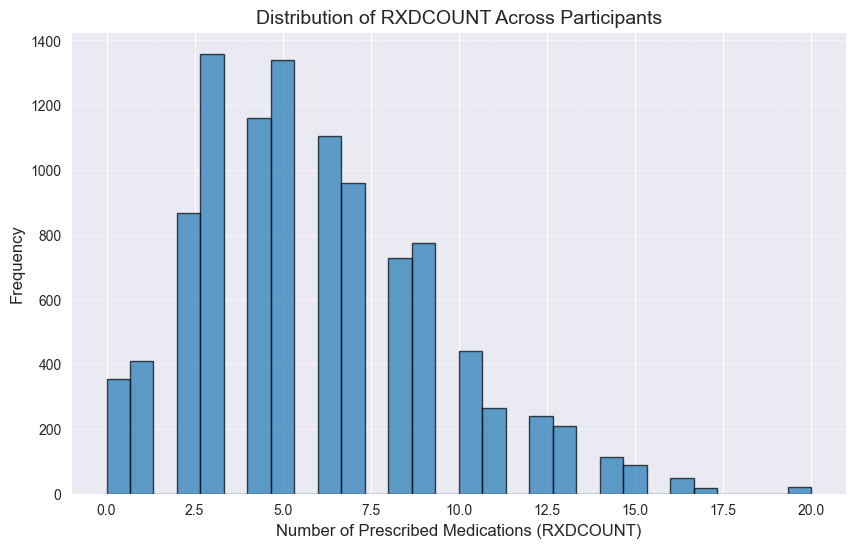

In [28]:


# Plot the distribution of RXDCOUNT (count of prescribed medications)
plt.figure(figsize=(10, 6))
data['RXDCOUNT'].dropna().plot(kind='hist', bins=30, edgecolor='black', alpha=0.7)
plt.title('Distribution of RXDCOUNT Across Participants', fontsize=14)
plt.xlabel('Number of Prescribed Medications (RXDCOUNT)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [29]:
# Load the newly uploaded file to find antihypertensive drugs
# data/raw_data/2005-2006/RXQ_RX_D.csv
new_file_path = '../data/raw_data/2005-2006/RXQ_RX_D.csv'
drug_data = pd.read_csv(new_file_path)

# Display the structure of the new file to understand its contents
drug_data_info = {
    "columns": drug_data.columns.tolist(),
    "head": drug_data.head(),
    "info": drug_data.info(),
}
drug_data_info


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18005 entries, 0 to 18004
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   SEQN      18005 non-null  float64
 1   RXDUSE    18005 non-null  float64
 2   RXDDRUG   11431 non-null  object 
 3   RXDDRGID  11369 non-null  object 
 4   RXQSEEN   11342 non-null  float64
 5   RXDDAYS   11370 non-null  float64
 6   RXDCOUNT  11431 non-null  float64
dtypes: float64(5), object(2)
memory usage: 984.8+ KB


{'columns': ['SEQN',
  'RXDUSE',
  'RXDDRUG',
  'RXDDRGID',
  'RXQSEEN',
  'RXDDAYS',
  'RXDCOUNT'],
 'head':       SEQN  RXDUSE           RXDDRUG RXDDRGID  RXQSEEN  RXDDAYS  RXDCOUNT
 0  31127.0     2.0               NaN      NaN      NaN      NaN       NaN
 1  31128.0     2.0               NaN      NaN      NaN      NaN       NaN
 2  31129.0     1.0  BUDESONIDE NASAL   d03640      2.0      3.0       1.0
 3  31130.0     2.0               NaN      NaN      NaN      NaN       NaN
 4  31131.0     1.0        CARVEDILOL   d03847      1.0    730.0       2.0,
 'info': None}

In [32]:
# Filter for potential antihypertensive drugs using keywords in the RXDDRUG column
antihypertensive_keywords = [
    "hydrochlorothiazide", "labetalol", "amlodipine", "losartan", "atenolol",
    "metoprolol", "captopril", "enalapril", "furosemide", "valsartan"
]
antihypertensive_drugs = drug_data[
    drug_data['RXDDRUG'].str.contains('|'.join(antihypertensive_keywords), case=False, na=False)
]

# Select relevant columns for clarity
antihypertensive_drugs = antihypertensive_drugs[['RXDDRGID', 'RXDDRUG']]

# Display the filtered data for antihypertensive drugs
# import ace_tools as tools; tools.display_dataframe_to_user(name="Antihypertensive Drugs Data", dataframe=antihypertensive_drugs)

antihypertensive_drugs.head(100)


,RXDDRGID,RXDDRUG
6,d00689,AMLODIPINE
7,d04293,HYDROCHLOROTHIAZIDE; VALSARTAN
12,d00004,ATENOLOL
15,d00253,HYDROCHLOROTHIAZIDE
33,d00004,ATENOLOL
...,...,...
1170,d00070,FUROSEMIDE
1173,d00134,METOPROLOL
1181,d03829,AMLODIPINE; BENAZEPRIL
1206,d00004,ATENOLOL


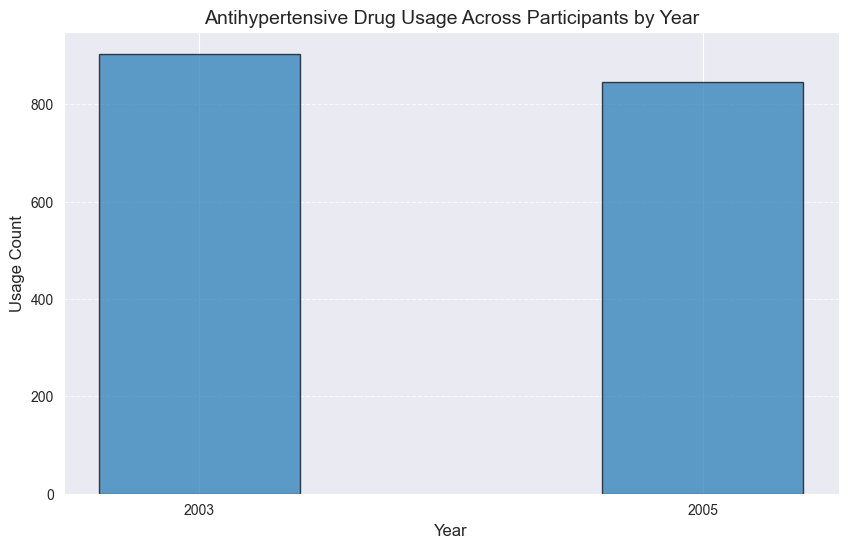

In [35]:
# Extract RXDDRGID and RXDDRUG for antihypertensives
antihypertensive_ids = antihypertensive_drugs['RXDDRGID'].dropna().tolist()

# Filter the initial dataset for rows with antihypertensive drugs
antihypertensive_usage = data[data['RXDDRGID'].isin(antihypertensive_ids)]

# Summarize the usage by year and participant
usage_summary = antihypertensive_usage.groupby('SourceYear').size().reset_index(name='UsageCount')

# Plot the antihypertensive drug usage over the years
plt.figure(figsize=(10, 6))
plt.bar(usage_summary['SourceYear'], usage_summary['UsageCount'], alpha=0.7, edgecolor='black')
plt.title('Antihypertensive Drug Usage Across Participants by Year', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Usage Count', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(usage_summary['SourceYear'].unique())
plt.show()

# Display summary of usage data to the user
#tools.display_dataframe_to_user(name="Antihypertensive Usage Summary", dataframe=usage_summary)


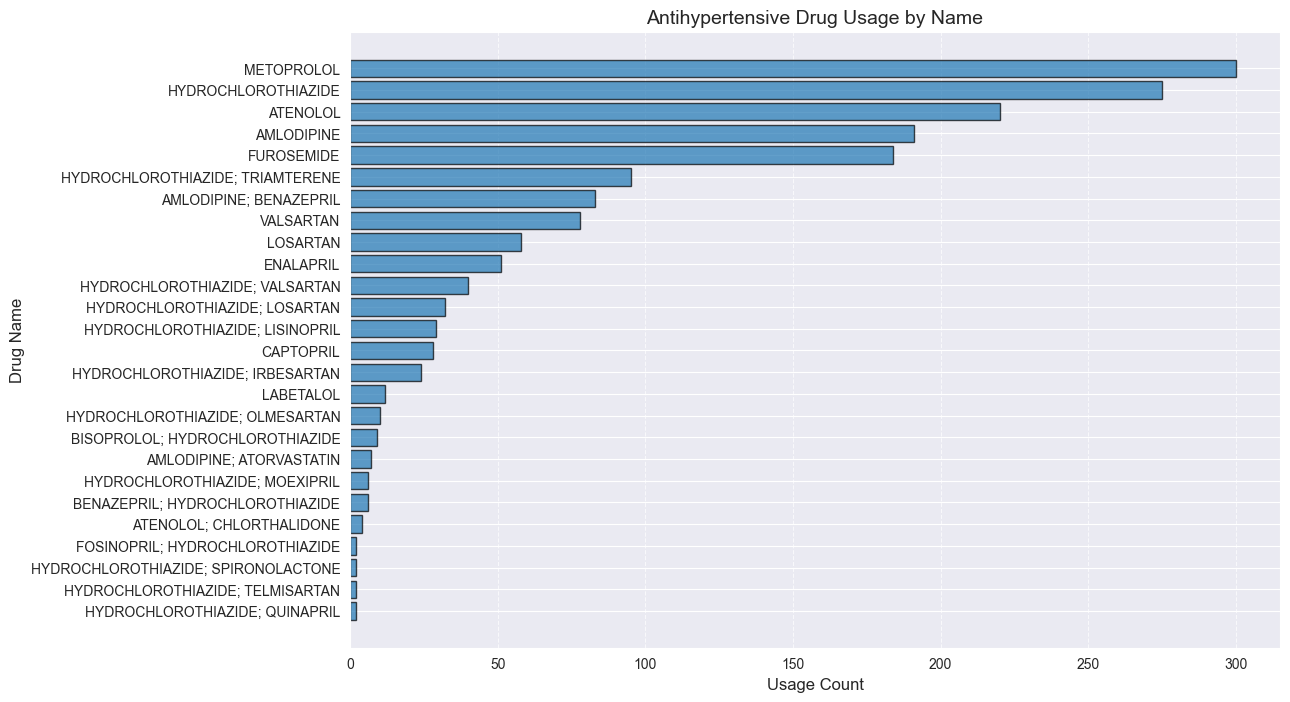

NameError: name 'tools' is not defined

In [36]:
# Group the antihypertensive usage data by drug name and count occurrences
antihypertensive_by_name = antihypertensive_usage.groupby('RXDDRUG').size().reset_index(name='UsageCount')

# Sort the data for better visualization
antihypertensive_by_name = antihypertensive_by_name.sort_values(by='UsageCount', ascending=False)

# Plot the usage of antihypertensive drugs by name
plt.figure(figsize=(12, 8))
plt.barh(antihypertensive_by_name['RXDDRUG'], antihypertensive_by_name['UsageCount'], alpha=0.7, edgecolor='black')
plt.title('Antihypertensive Drug Usage by Name', fontsize=14)
plt.xlabel('Usage Count', fontsize=12)
plt.ylabel('Drug Name', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()

# Display the grouped data to the user
tools.display_dataframe_to_user(name="Antihypertensive Usage by Drug Name", dataframe=antihypertensive_by_name)


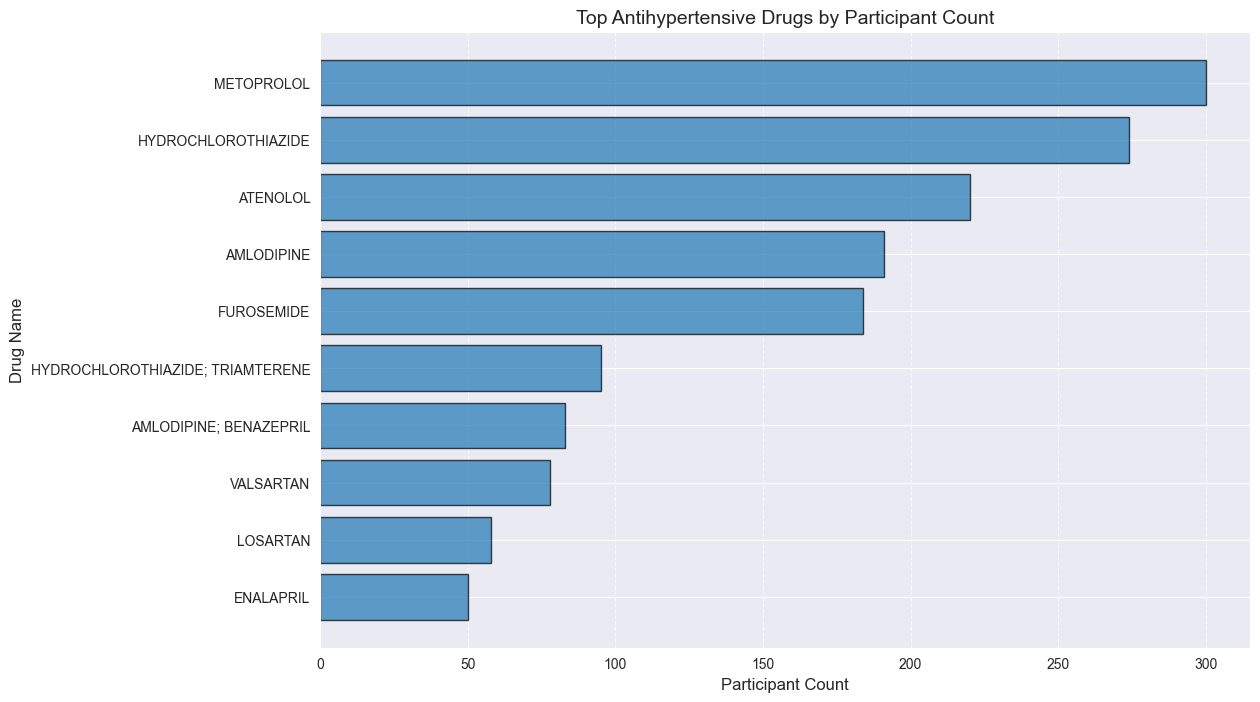

In [38]:
# Count unique participants for each antihypertensive drug
top_drugs_participant_count = (
    antihypertensive_usage.groupby('RXDDRUG')['SEQN']
    .nunique()
    .reset_index(name='ParticipantCount')
    .sort_values(by='ParticipantCount', ascending=False)
    .head(10)  # Top 10 drugs by participant count
)

# Plot the top drugs by participant count
plt.figure(figsize=(12, 8))
plt.barh(top_drugs_participant_count['RXDDRUG'], top_drugs_participant_count['ParticipantCount'], alpha=0.7, edgecolor='black')
plt.title('Top Antihypertensive Drugs by Participant Count', fontsize=14)
plt.xlabel('Participant Count', fontsize=12)
plt.ylabel('Drug Name', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()

# Display the data
#tools.display_dataframe_to_user(name="Top Antihypertensive Drugs by Participant Count", dataframe=top_drugs_participant_count)


The work is in progress. Next steps: Organize data, add data, clean data files, explore features, conduct extensive correlation analyses, conduct statistical analyses and modeling.  